## 1. Importing libraries

In [32]:
import torch
import gym
import numpy as np
import cv2
import time
import math
import random
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler

import warnings
import os
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, Flatten, Linear, MSELoss
from torch.optim import Adam
from torchinfo import summary

In [33]:
warnings.filterwarnings("ignore")

## 2. Checking availability of GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn)
    print('Device name:', torch.cuda.get_device_name(0))

Device:  cuda
__CUDNN VERSION: <module 'torch.backends.cudnn' from 'c:\\Users\\mario\\anaconda3\\envs\\AI701Project\\lib\\site-packages\\torch\\backends\\cudnn\\__init__.py'>
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


## 3. Creating the environment

In [3]:
env_si = gym.make("ALE/SpaceInvaders-v5")
env_si.seed(0);

env_c = gym.make("ALE/Carnival-v5")
env_c.seed(0);

env_ar = gym.make("ALE/AirRaid-v5")
env_ar.seed(0);

## 4. Performance of a random policy

In [4]:
def random_play(env):
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
        time.sleep(0.001)
    env.close()

In [5]:
random_play(env_si)

c:\Users\mario\anaconda3\envs\AI701Project\lib\site-packages\gym\envs\atari\environment.py:267: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(
C:\Users\mario\AppData\Roaming\Python\Python38\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Your Score at end of game is:  575.0


In [6]:
random_play(env_c)

Your Score at end of game is:  460.0


In [7]:
random_play(env_ar)

Your Score at end of game is:  550.0


## 5. Exploring the environments

In [5]:
for env in [env_si, env_c, env_ar]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(ALE/SpaceInvaders-v5) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/Carnival-v5) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(ALE/AirRaid-v5) frame is:  (250, 160, 3)
No. of Actions:  6


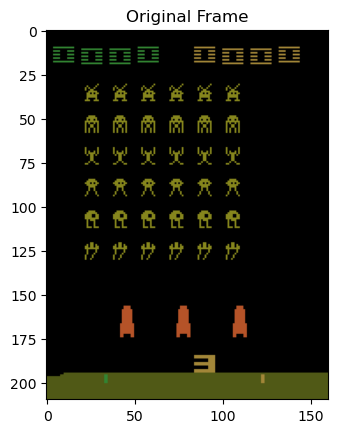

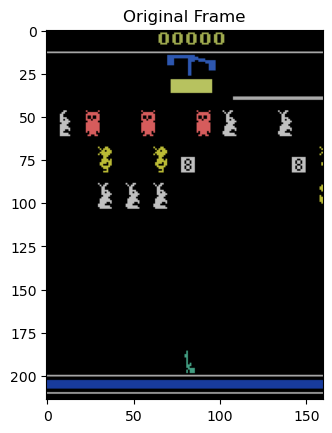

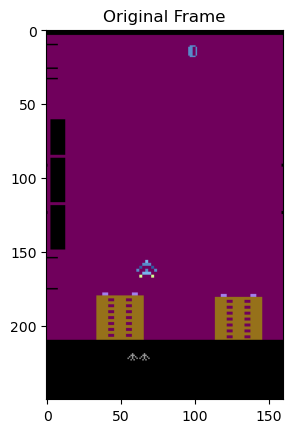

In [6]:
for env in [env_si, env_c, env_ar]:
    env.reset()
    plt.figure()
    plt.imshow(env.reset())
    plt.title('Original Frame')
    plt.show()

## 6. Image preprocessing and stacking frames

#### 6.1 Functions

In [7]:
def preprocess_state(state, game):
    # []
    game_name = str(game.spec)
    if game_name == "EnvSpec(ALE/SpaceInvaders-v5)":
        #initially, the image has a shape of (210, 160, 3)

        #crop and resize the image
        #image = state[19:195:1, ::1]
        image = state[25:201:2, ::2]

        #now the image has a shape of (176, 160, 3)

    elif game_name == "EnvSpec(ALE/Carnival-v5)":
        #initially, the image has a shape of (210, 160, 3)

        #crop and resize the image
        #image = state[19:195:1, ::1]
        image = state[36:207:2, :158:2]

        #now the image has a shape of (176, 160, 3)

    elif game_name == "EnvSpec(ALE/AirRaid-v5)":
        #initially, the image has a shape of (210, 160, 3)

        #crop and resize the image
        #image = state[19:195:1, ::1]
        image = state[18:210:2, 8::2]

        #now the image has a shape of (176, 160, 3)


    #convert rgb image to grayscale
    #image = np.average(image,axis = 2)
    image = image.mean(axis = 2)
    scaler = MinMaxScaler()
    model = scaler.fit(image)
    image = model.transform(image)

    # Next we normalize the image from -1 to +1
    #image = (image - 128) / 128 - 1
    #image = image / 255
    #8-bit image

    #reshape the image
    image = cv2.resize(image,(84, 84),interpolation = cv2.INTER_NEAREST) # 76

    #print(image.shape, image.dtype)

    return image

out = preprocess_state(env_si.reset(), env_si)
#plt.figure()
#plt.imshow(out, cmap= "gray")
#plt.title('SpaceInvaders-v5')

In [8]:
observation = env_si.reset()

In [9]:
observation.shape

(210, 160, 3)

In [10]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode, env):
    # Preprocess frame
    frame = preprocess_state(state, env_si)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    stacked_state = torch.from_numpy(stacked_state)
    stacked_state = torch.reshape(stacked_state, (1, stacked_state.shape[2],stacked_state.shape[0], stacked_state.shape[1]))    
    
    return stacked_state, stacked_frames

In [11]:
observation = env_si.reset()

In [12]:
observation, stacked_observation = stack_frames(stacked_frames, observation, True, env_si)

#### 6.2 Image preview

In [13]:
observation.shape

torch.Size([1, 4, 84, 84])

## 7. Hyperparameters

In [14]:
def START_seed():
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [15]:
input_shape = (84, 84, 4)
action_size = env_si.action_space.n
n_stacked_frames = 4
START_seed()
gamma = 0.99           # discount factor
buffer_size = 20000   # replay buffer size
pretrain_length = 1000 # Number of experiences used to filled an initialiazed memory
batch_size = 64        # Update batch size
learning_rate = 0.0001            # learning rate 
tau = 1e-3             # for soft update of target parameters
update_every = 1       # how often to update the network
update_after = 10000  # After which thershold replay to be started

# Exploration vs Explotaition tradeoff, epsilon decays over time
eps_start = 0.99        # starting value of epsilon
eps_end = 0.01          # Ending value of epsilon
eps_decay = 100         # Rate by which epsilon to be decayed

## 8. Neural networks

In [16]:
class DQN(nn.Module):

    def __init__(self, model_path='models/model.pt'):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.model_path = model_path

    def build_model(self, n_stacked_frames, n_actions, learning_rate):
        self.n_actions = n_actions
       # Architecture proposed in https://arxiv.org/abs/1312.5602

        self.model = Sequential(OrderedDict([
        ('conv_1', Conv2d(in_channels=n_stacked_frames, out_channels=16, kernel_size=(4, 4), stride=(4, 4))),
        ('activation_1', ReLU()),
        ('conv_2', Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=(2, 2))),
        ('activation_2', ReLU()),
        ('flatten', Flatten()),
        ('linear_1', Linear(in_features=2592, out_features=256)),
        ('activation_4', ReLU()),
        ('linear_2', Linear(in_features=256, out_features=n_actions))]))

        self.optimizer = Adam(lr=learning_rate, params=self.model.parameters())
        self.criterion = MSELoss()
        self.model.to(self.device)

        # create model file if not present
        if not os.path.isfile(self.model_path):
            self.save_model()

    def print_model(self):
        summary(model=self.model, input_size=(1, 4, 84, 84))

    def predict(self, state):
        state_tensor = torch.tensor(state)
        return self.model(state_tensor.float().to(device))

    def save_model(self):

        print('Saving model')
        torch.save({
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self, training=False):
        
        state = torch.load(self.model_path)

        if training:
            print('Loading model to continue training')
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            self.model.train()
        else:
            print('Loading model for inference')
            self.model.load_state_dict(state['state_dict'])
            self.model.eval()

## 9. The Replay Memory

In [17]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size = batch_size, replace = False)
        return [self.buffer[i] for i in index]

    def populating_memory(self, pretrain_length, env):
        for i in range(pretrain_length):
            # If it's the first step
            if i == 0:
                stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
                state = env.reset()
                state, stacked_frames = stack_frames(stacked_frames, state, True, env)
            # Get the next_state, the rewards, done by taking a random action
            action = random.randint(0,action_size-1)
            next_state, reward, done, _ = env.step(action)

            # Stack the frames
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False, env)
        
            # If the episode is finished (we're dead 3x)
            if done:
                # We finished the episode
                next_state = np.zeros(state.shape)
                
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Start a new episode
                state = env.reset()
                
                # Stack the frames
                state, stacked_frames = stack_frames(stacked_frames, state, True, env)
                
            else:
                # Add experience to memory
                self.add((state, action, reward, next_state, done))
                
                # Our new state is now the next_state
                state = next_state

In [18]:
memory = Memory(max_size = buffer_size)

In [19]:
type(memory)

__main__.Memory

In [20]:
memory.populating_memory(pretrain_length, env_si)

In [21]:
memory.sample(16)[0][4]

False

## 9. Watching it play before training

## 10. Training the agent

#### 10.1 Decay of epsilon

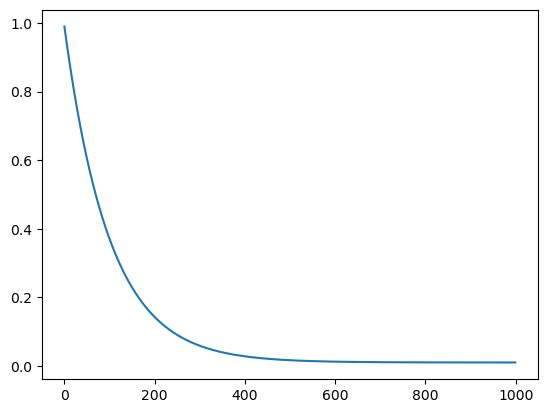

In [22]:
epsilon_by_episode = lambda frame_idx: eps_end + (eps_start - eps_end) * math.exp(-1. * frame_idx /eps_decay)
plt.plot([epsilon_by_episode(i) for i in range(1000)])

#### 10.2 Main training algorithm

![alt text](dql_algorithm.jpg "Title")

In [23]:


START_seed()
transform = transforms.ToTensor()

In [24]:
def train(n_episodes=1000, game=env_si):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    start_epoch = 0
    scores = []
    scores_window = deque(maxlen=20)
    stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    ########### Initialize replay memory D to capacity N (most of the sources indicate that N should be 1 million)
    memory = Memory(20000)
    memory.populating_memory(1000, env_si)
    ########### Initialize action-value function Q with random weights Theta
    Q = DQN()
    Q.build_model(n_stacked_frames, action_size, learning_rate)
    ########### Initialize target action-value function Q_hat with weights Theta_ = Theta
    Q_hat = DQN()
    Q_hat.build_model(n_stacked_frames, action_size, learning_rate)
    Q_hat.load_state_dict(Q.state_dict())
    
    optimizer = Adam(lr=learning_rate, params=Q.parameters())
    #loss = MSELoss()

    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = game.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True, game)
        score = 0
        eps = epsilon_by_episode(i_episode)
        C = 0
        while True:

            if random.random() <= eps:
                #print('|======= RANDOM ACTION =======|')
                a_t = random.randrange(action_size)
            else:
                q = Q.predict(state)
                a_t = torch.argmax(q)

            action = a_t ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy

            next_state, reward, done, _ = game.step(action)
            
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False, game) ############ Here we need the preprocessing function

            ############### Here we store the transition (phi_(t), a_(t), r_(t), phi_(t+1)) in D
            memory.add((state, action, reward, next_state, done))

            ################# Training phase ######################
            ####### 1.- Sample random minibatch with uniform distribution of transitions (phi_(j), a_(j), r_(j), phi_(j+1)) from D
            minibatch = memory.sample(16)
            ####### 2.- Calculate the target value "y"
            x = np.array([])
            x = torch.from_numpy(x)
            #target_q_values = torch.tensor([]).to(device)
            #s_t1_q_values = torch.tensor([]).to(device)
            
            target_q_values = x.clone().detach().requires_grad_(True).to(device)
            s_t1_q_values = x.clone().detach().requires_grad_(True).to(device)

            


            for s_t, a_t, r_t, s_t1, done in minibatch:

                target = Q.predict(s_t)  # Predicted Q values
                q_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state
                #q_s_t1 = torch.tensor(q_s_t1).to(device)

                #target[:, a_t] = r_t + (1 - done) * gamma * torch.max(q_s_t1)
                #print(f"r_t {r_t} {type(r_t)}, done {done} {type(done)}, gamma {gamma} {type(gamma)}")
                target[:, a_t] = r_t + (1 - done) * gamma * torch.max(q_s_t1)
                #print(target)
            
                #target[:, a_t] = 
                #x = r_t + (1 - done) * gamma
                #print(x)
                target_q_values = torch.cat((target_q_values, target), dim=0)
                s_t1_q_values = torch.cat((s_t1_q_values, q_s_t1), dim=0)

            ####### 3.- Perform ADAM step on ACTION-VALUE function, not target action-value function

            loss = nn.MSELoss()(target_q_values, s_t1_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_test = loss.item()

            state = next_state
            score += reward

            ############### Every C steps reset Q_hat = Q, we train only on Q
            if C % 3 == 0:
                Q_hat.load_state_dict(Q.state_dict())
                
            if done:
                break

        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Plotting
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    
    return Q, scores

Episode 10	Average Score: 55.00


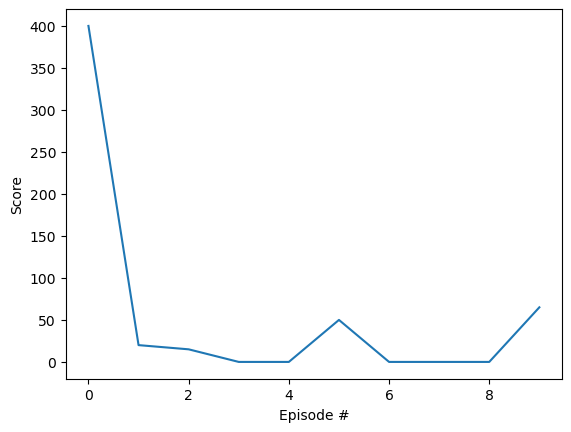

Episode 20	Average Score: 36.25


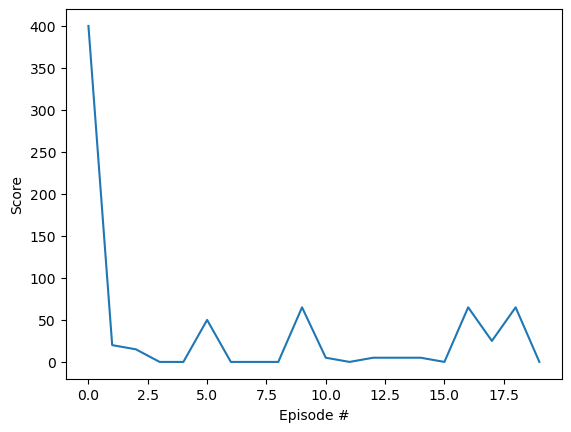

Episode 30	Average Score: 10.50


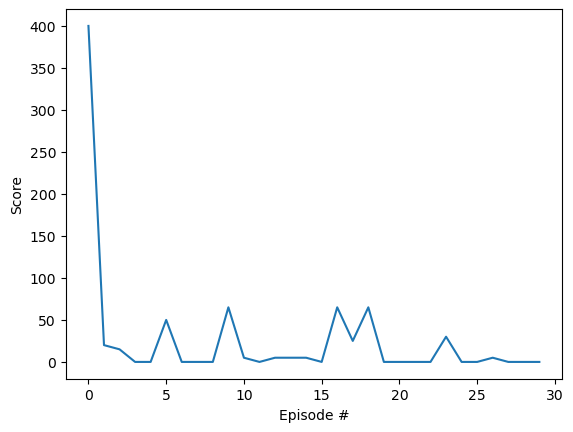

Episode 40	Average Score: 10.25


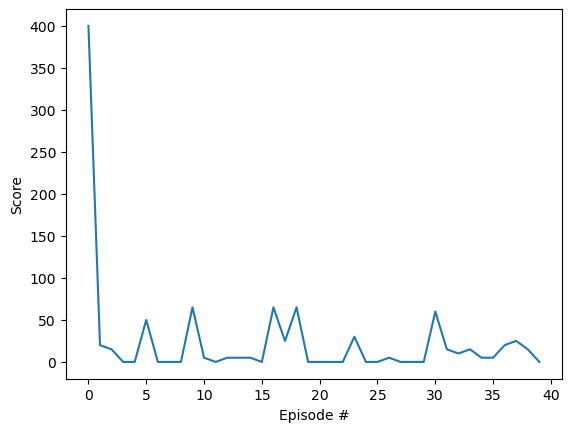

Episode 50	Average Score: 14.50


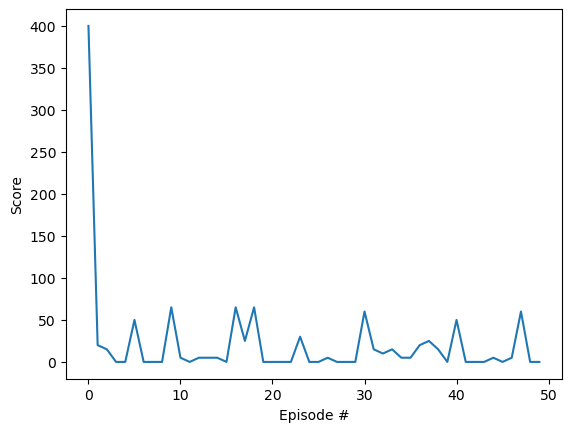

Episode 60	Average Score: 7.255


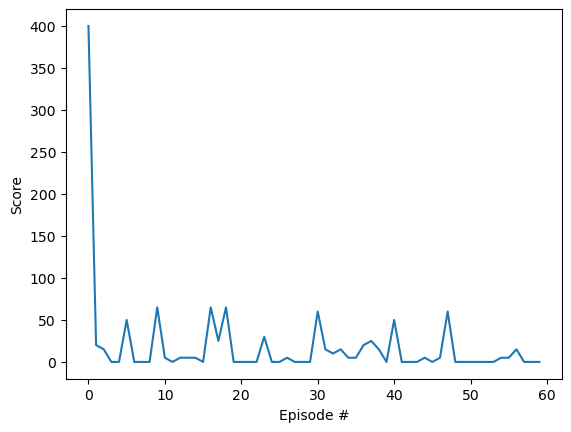

Episode 70	Average Score: 1.25


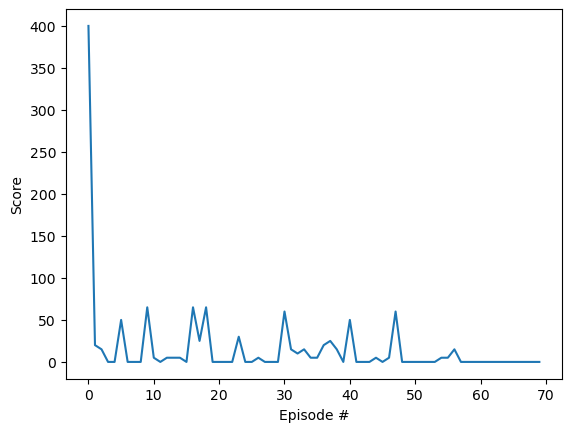

Episode 80	Average Score: 1.00


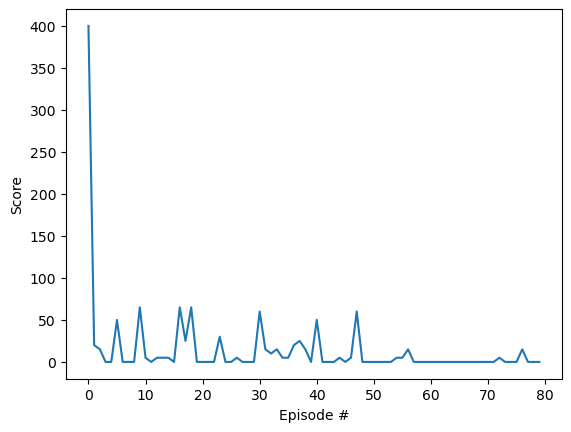

Episode 90	Average Score: 5.25


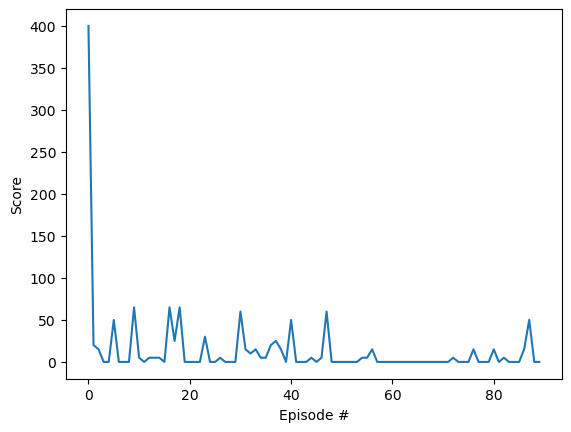

Episode 100	Average Score: 7.75


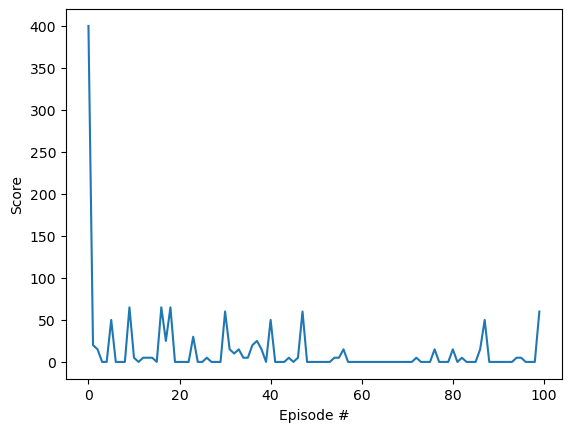

Episode 110	Average Score: 8.255


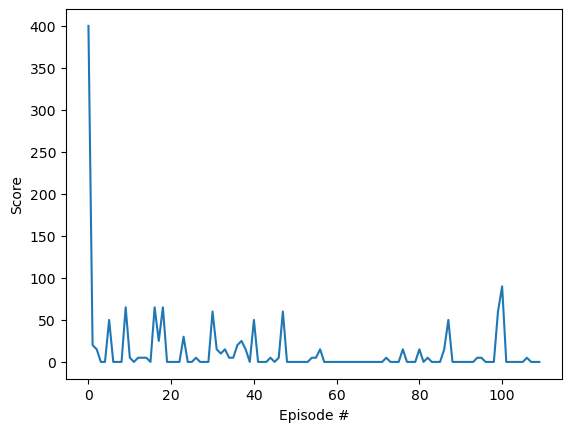

Episode 120	Average Score: 12.00


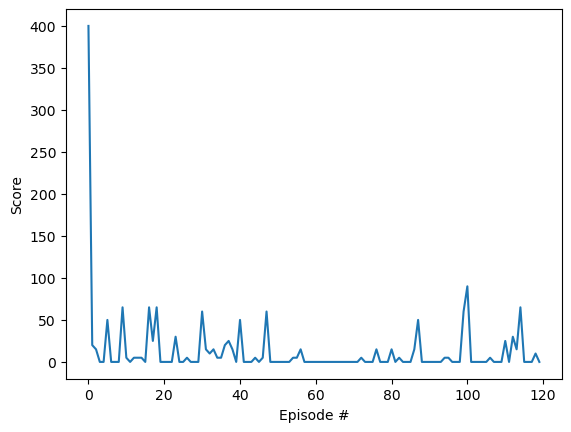

Episode 130	Average Score: 11.00


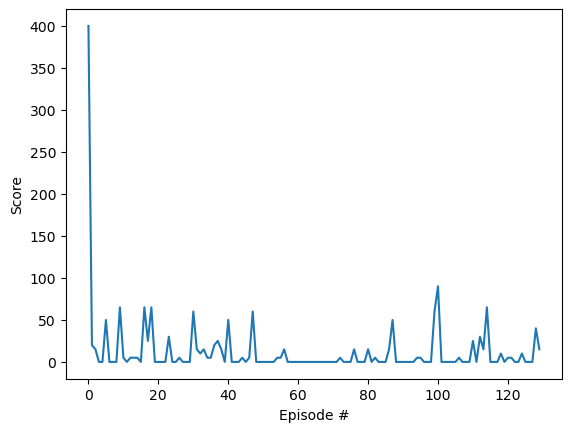

Episode 140	Average Score: 11.50


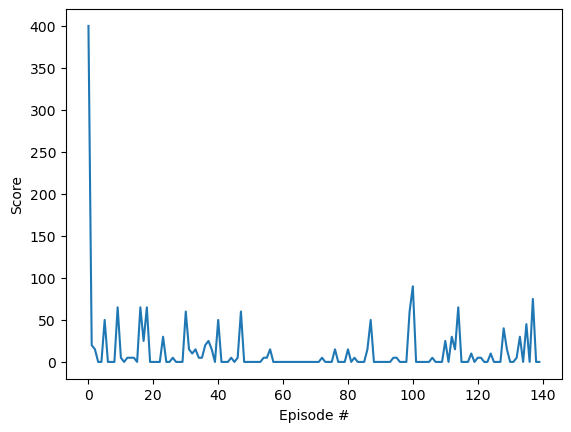

Episode 150	Average Score: 7.750


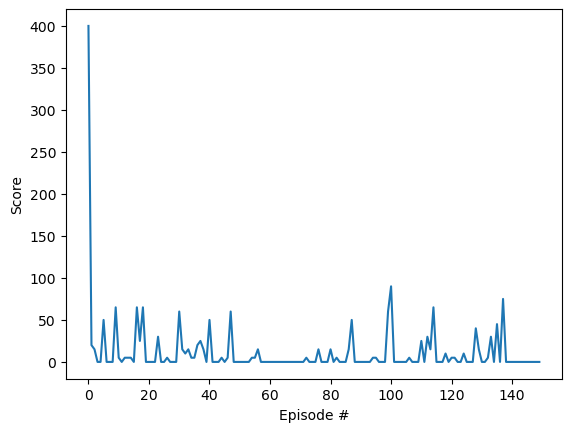

Episode 160	Average Score: 4.005


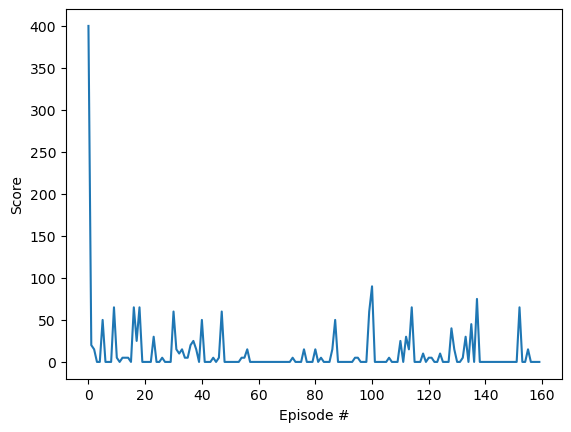

Episode 170	Average Score: 5.50


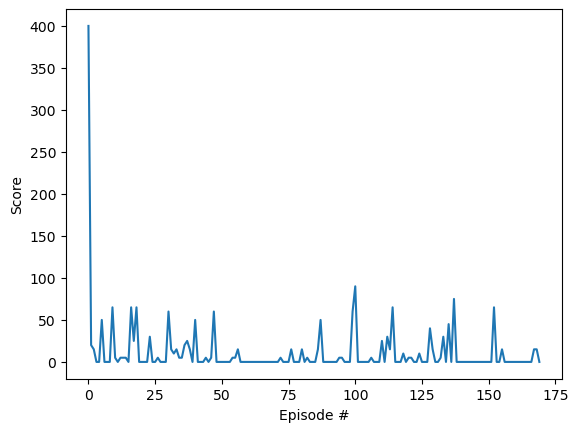

Episode 180	Average Score: 5.50


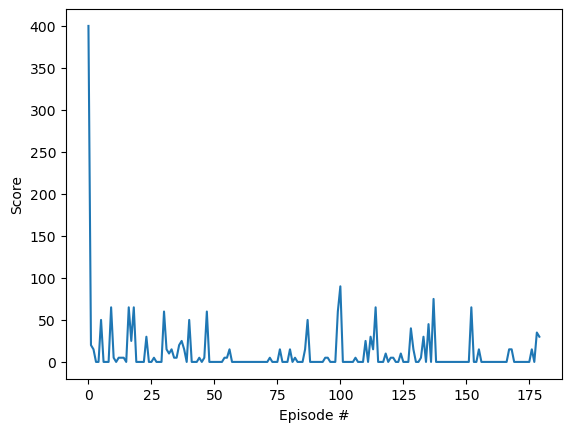

Episode 190	Average Score: 4.50


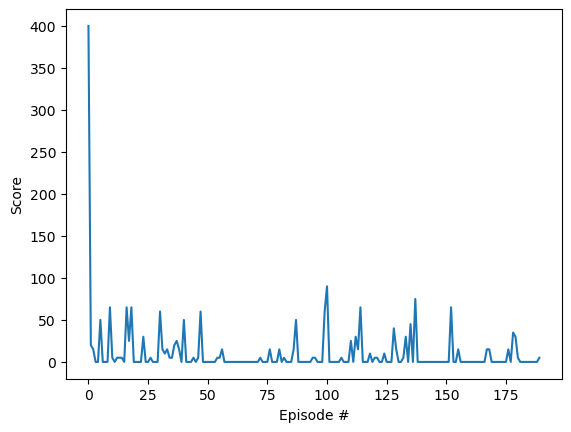

Episode 200	Average Score: 4.50


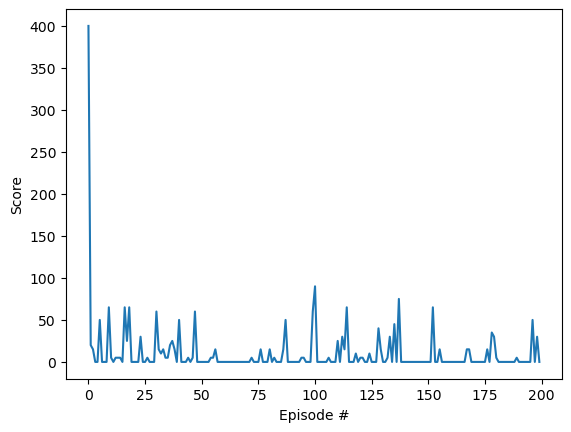

Episode 210	Average Score: 12.25


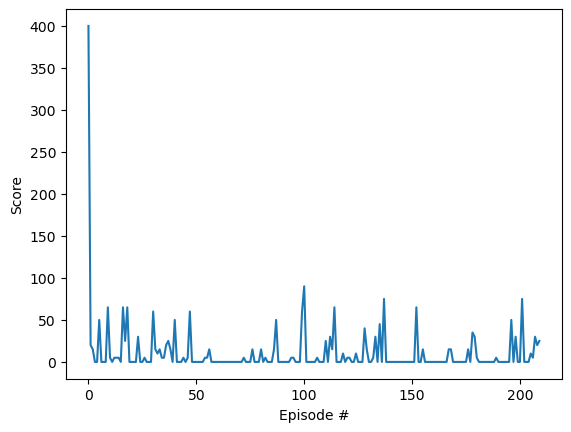

Episode 220	Average Score: 15.00


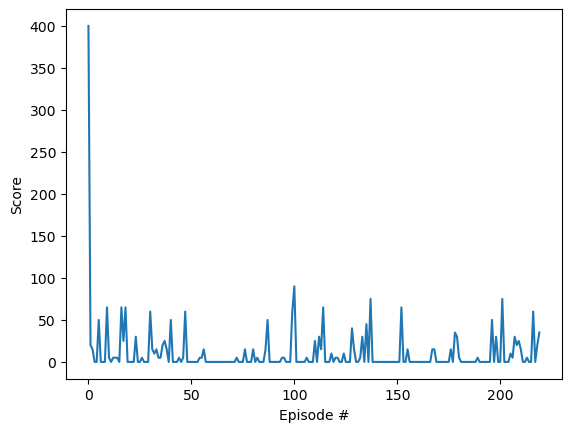

Episode 230	Average Score: 12.75


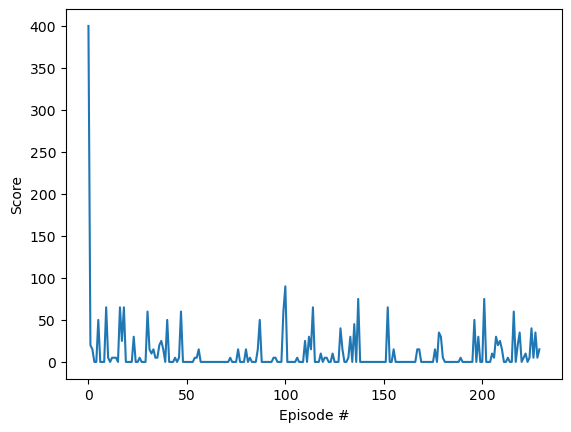

Episode 240	Average Score: 19.50


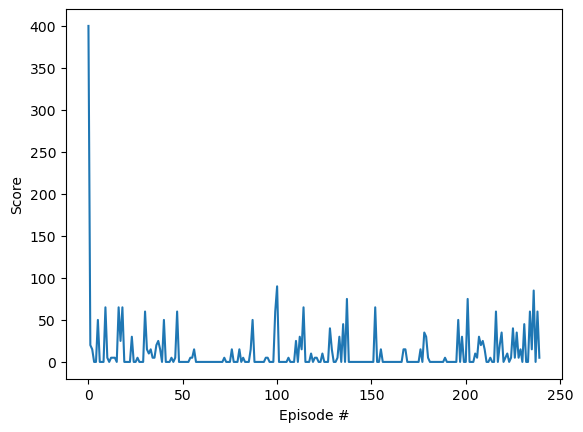

Episode 250	Average Score: 14.50


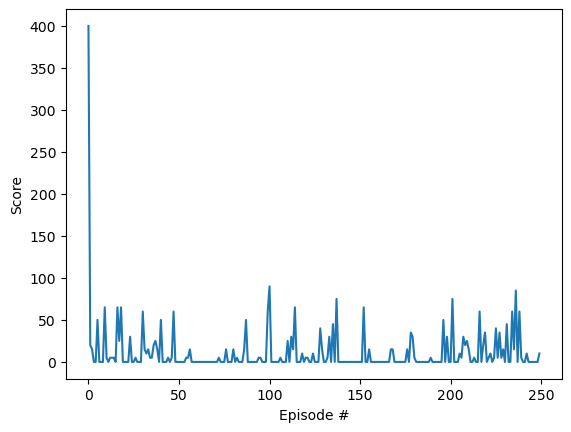

Episode 260	Average Score: 6.250


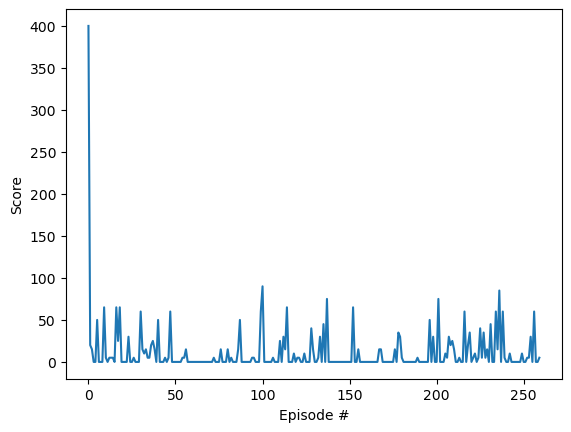

Episode 270	Average Score: 20.00


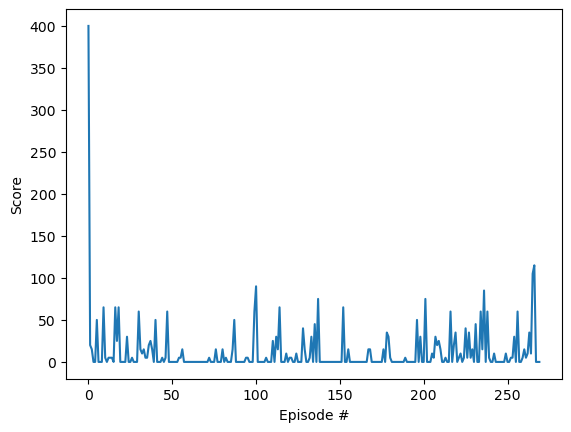

Episode 280	Average Score: 16.50


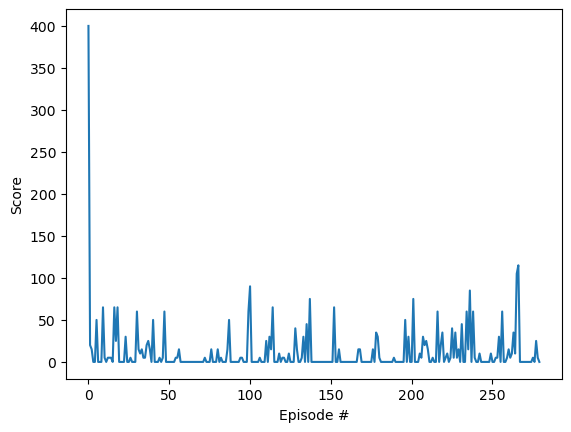

Episode 290	Average Score: 4.000


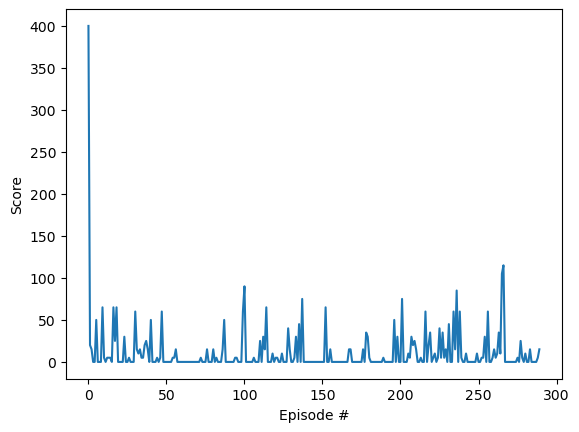

Episode 300	Average Score: 3.25


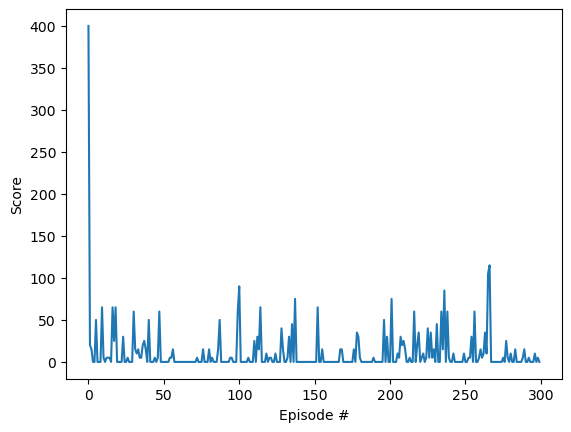

In [35]:
model, scores = train(300, env_si)

## 11. Evaluate the agent

In [36]:
score = 0
observation = env_si.reset()
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
state, stacked_frames_deque = stack_frames(stacked_frames, observation, True, env_si) ############ Here we need the preprocessing function
while True:
    env_si.render()
    q = model.predict(state)
    a_t = torch.argmax(q) ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
    next_state, reward, done, _ = env_si.step(a_t)
    score += reward
    state, stacked_frames_deque = stack_frames(stacked_frames_deque, next_state, False, env_si) ########## Here we need the preprocessing function
    if done:
        print("You Final score is:", score)
        break
    time.sleep(0)
env_si.close()

You Final score is: 0.0
